In [20]:
import pandas as pd
from sklearn.utils import shuffle
import os
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
import copy

import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
import itertools
from scipy.ndimage.interpolation import shift
import copy
import warnings
#warnings.filterwarnings("ignore")
plt.ion()
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pydicom

In [25]:
class MamogramDataset_TL(Dataset):

    def __init__(self, csv_file, root_dir, image_column, num_channel, transform=None,
                transform_type = 'Custom', transform_prob=0.5):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            image_column (string): name of the column image used
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.image_column = image_column
        self.num_channel = num_channel
        self.transform_prob = transform_prob
        self.transform_type = transform_type
        self.samples = []
        
        for idx in range(len(self.data_frame)):
            image_name = os.path.join(self.root_dir,
                                    self.data_frame.loc[idx, image_column])

            image = pydicom.dcmread(image_name).pixel_array
            
            if self.num_channel > 1:
                image = np.uint8(image/65535*255)
                image = np.repeat(image[...,None],self.num_channel,axis=-1)
            else:
                h,w = image.shape
                resized_h = 1024
                resized_w = int(resized_h/h*w)
                image = transform.resize(image, (resized_h, resized_w), anti_aliasing=True,mode='constant')
                pad_col = resized_h-resized_w
                image = np.pad(image,((0,0),(0,pad_col)),mode='constant',constant_values=0)
                image = (image - image.mean()) / image.std()
                image = image[None,...]

            image_class = self.data_frame.loc[idx, 'class']

            if self.transform:
                image = self.transform(image)
            elif self.transform_type == 'Custom':
                p1 = random.uniform(0, 1)
                p2 = random.uniform(0, 1)
                if p1 <= self.transform_prob:
                    image = image[:,:,-1].copy()
                if p2 <= self.transform_prob:
                    image = transform.rotate(image,180)

            sample = {'x': image, 'y': image_class}
            self.samples.append(sample)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        return self.samples[idx]

In [18]:
def GetDataLoader_TL(train_csv, validation_csv, test_csv, root_dir, image_column, num_channel, 
                     transform_type, transform_prob, 
               train_transform, validation_transform, 
               batch_size, shuffle, num_workers): 

    train_data = MamogramDataset_TL(csv_file = train_csv, 
                              root_dir = root_image,
                              image_column = image_column,
                              num_channel = num_channel, 
                               transform=train_transform, 
                               transform_type = transform_type, 
                                   transform_prob = transform_prob)
    val_data = MamogramDataset_TL(csv_file = validation_csv, 
                            root_dir = root_image,
                            image_column = image_column,
                            transform = validation_transform,
                                 num_channel = num_channel, 
                               transform_type = transform_type, 
                                   transform_prob = transform_prob)
    test_data = MamogramDataset_TL(csv_file = test_csv, 
                            root_dir = root_image,
                            image_column = image_column,
                            transform = None,
                            num_channel = num_channel, 
                               transform_type = transform_type, 
                                   transform_prob = transform_prob)
    
    image_datasets = {'train': train_data, 'val': val_data, 'test': test_data}
#     train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,
#                             shuffle = shuffle, num_workers = NUM_WORKERS)
#     val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,
#                             shuffle = shuffle, num_workers = NUM_WORKERS)
#     test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,
#                             shuffle = shuffle, num_workers = NUM_WORKERS)
    

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True, 
                                              num_workers=NUM_WORKERS) 
                    for x in ['train', 'val', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
#     print(len(image_datasets['train']), 
#           len(image_datasets['val']),
#          len(image_datasets['test']))
    return dataloaders, dataset_sizes

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 10,verbose = True):

    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    acc_dict = {'train':[],'validation':[]}
    loss_dict = {'train':[],'validation':[]}

    for epoch in range(num_epochs):
        if verbose:
#             if epoch % 5 == 4:
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)
            
        for phase in ['train','val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                
                inputs = data['x']
                labels = data['y']
                
                # wrap them in Variable
                if use_gpu:
                    inputs = inputs.type(torch.FloatTensor).to(device)
                    labels = labels.to(device)
                else:
                    inputs = Variable(inputs).type(torch.FloatTensor)
                    labels = Variable(labels).type(torch.LongTensor)

                    
                optimizer.zero_grad()

                out = model(inputs)
                _, preds = torch.max(out, dim = 1)
                loss = criterion(out, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size()[0]
                running_corrects += torch.sum(preds == labels).item()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if verbose:
#                 if epoch % 5 == 4:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                loss_dict['train'].append(epoch_loss)
                acc_dict['train'].append(epoch_acc)
            else:
                loss_dict['validation'].append(epoch_loss)
                acc_dict['validation'].append(epoch_acc)
                    
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                scheduler.step(epoch_loss)

    time_elapsed = time.time() - start_time
    print('Training time: {}minutes {}s'.format(int(time_elapsed / 60), time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # for i, phase in enumerate(['train','validation']):

    #     fig = plt.figure()
        
    #     a = fig.add_subplot(1,2,1*i+1)
    #     plt.plot(loss_dict[phase])
    #     plt.title('Loss per epoch for ' + phase)

    #     a = fig.add_subplot(1,2,1*i+2)
    #     plt.plot(acc_dict[phase])
    #     plt.title('Accuracy per epoch for ' + phase)
    #     plt.show()
    #     plt.savefig(os.path.join(graph_path ,'Curve {}.png'.format(phase)))

    model.load_state_dict(best_model_wts)
    torch.save(model, os.path.join(graph_path, 'BestResNet34_tl.pt'))
    
    return {'Model': model, 'LossDict': loss_dict, 'AccDict': acc_dict}

In [28]:
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([2048,2048]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([2048,2048]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [29]:
# ######### Local Machine Paths ######## 
excel_path = '/Users/nhungle/Box/Free/Data-Science-Projects/Breast_Cancer_Diagnosis/excel_files'
train_local_csv = os.path.join(excel_path, 
                              'train_local.csv')
validation_local_csv = os.path.join(excel_path, 
                              'validation_local.csv')
test_local_csv = os.path.join(excel_path, 
                              'test_local.csv')

image_path = '/Users/nhungle/Box/Free/Data-Science-Projects/Breast_Cancer_Diagnosis'
root_image = os.path.join(image_path ,'images')

NUM_WORKERS = 1
BATCH_SIZE = 1
graph_path = '/Users/nhungle/Box/Free/Data-Science-Projects/Breast_Cancer_Diagnosis/graphs'


In [ ]:
# ######### HPC Paths ######## 
# excel_path = '/home/nhl256/BreastCancer/excel_files'
# train_local_csv = os.path.join(excel_path, 
#                              'trainSet.csv')
# validation_local_csv = os.path.join(excel_path, 
#                               "validationSet.csv")
# test_local_csv = os.path.join(excel_path, 
#                               "testSet.csv")

# image_path = '/scratch/bva212/breastCancerData'
# root_image = os.path.join(image_path ,'CBIS-DDSM')

# NUM_WORKERS = 4
# BATCH_SIZE = 16
# graph_path = '/home/nhl256/HW2'


In [51]:
# t = pd.read_csv(os.path.join(excel_path, 'twoClass_trainSet.csv'))
# t.columns

In [30]:
use_gpu = torch.cuda.is_available()
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### Get Dataloaders and Datasets_sizes
dataloaders, dataset_sizes = GetDataLoader_TL(train_csv = train_local_csv, 
                                            validation_csv = validation_local_csv, 
                                            test_csv = test_local_csv, 
                                            root_dir = root_image, 
                                           image_column = 'local_image',
                                            num_channel = 3, 
                                            transform_type = None, 
                                              transform_prob=0.5,
               train_transform = train_transform, validation_transform = validation_transform, 
               batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS) 

In [31]:
resNet34_tl = torchvision.models.resnet34(pretrained=True)
for param in resNet34_tl.parameters():
    param.requires_grad = False

fc_in_features = resNet34_tl.fc.in_features
resNet34_tl.fc = torch.nn.Linear(fc_in_features, 2)

In [42]:
resNet34_tl = resNet34_tl#.to(device)

optimizer = torch.optim.SGD(resNet34_tl.fc.parameters(), lr = 0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

BestResNet34_tl = train_model(resNet34_tl, criterion, optimizer, scheduler, num_epochs = 10, verbose = True)

Epoch 1/10
----------
train Loss: 4.0729 Acc: 0.0000
val Loss: 7.9798 Acc: 0.0000
Epoch 2/10
----------
train Loss: 9.4707 Acc: 0.0000
val Loss: 0.0001 Acc: 1.0000
Epoch 3/10
----------
train Loss: 3.2241 Acc: 0.5000
val Loss: 13.1300 Acc: 0.0000
Epoch 4/10
----------
train Loss: 7.6314 Acc: 0.2500
val Loss: 0.0002 Acc: 1.0000
Epoch 5/10
----------
train Loss: 4.0212 Acc: 0.5000
val Loss: 7.9626 Acc: 0.0000
Epoch 6/10
----------
train Loss: 14.7598 Acc: 0.5000
val Loss: 20.3671 Acc: 0.0000
Epoch 7/10
----------
train Loss: 7.4678 Acc: 0.5000
val Loss: 0.0000 Acc: 1.0000
Epoch 8/10
----------
train Loss: 9.3865 Acc: 0.5000
val Loss: 7.6852 Acc: 0.0000
Epoch 9/10
----------
train Loss: 4.9972 Acc: 0.2500
val Loss: 0.3210 Acc: 1.0000
Epoch 10/10
----------
train Loss: 0.7684 Acc: 0.7500
val Loss: 7.8103 Acc: 0.0000
Training time: 8minutes 20.797785997390747s
Best val Acc: 1.000000


In [45]:
##### Plot #####
def PlotAccLoss(model, model_name): 
    fig, ax = plt.subplots()
    for key in model['LossDict']: 
        ax.plot(model['LossDict'][key], label = key)
    ax.set_title('Train and Validation Loss Curves')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    legend = ax.legend(loc= 'best', shadow=True,
                          bbox_to_anchor = (0.5, 0, 0.5, 0.5), ncol = 1, prop = {'size': 10})
    plt.savefig(os.path.join(graph_path ,'LossCurves_{}.png'.format(model_name)))

    fig, ax = plt.subplots()
    for key in model['AccDict']: 
        ax.plot(model['AccDict'][key], label = key)
    ax.set_title('Train and Validation Loss Curves')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epochs')
    legend = ax.legend(loc= 'best', shadow=True,
                          bbox_to_anchor = (0.5, 0, 0.5, 0.5), ncol = 1, prop = {'size': 10})
    plt.savefig(os.path.join(graph_path ,'AccuracyCurves_{}.png'.format(model_name)))

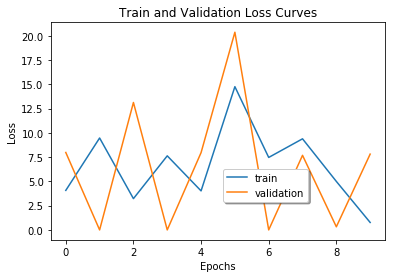

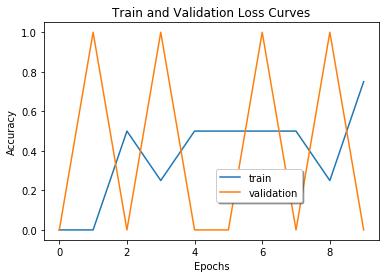

In [46]:
PlotAccLoss(BestResNet34_tl, 'ResNet34')

In [59]:
def inference(model_ft,loader):
    model_ft.eval()
    whole_output =[]
    whole_target = []
    

    for valData in loader:
        data = valData['x']
        target = valData['y']
        if use_gpu:
            data = Variable(data,volatile=True).type(torch.FloatTensor).cuda()
            target = Variable(target,volatile=True).type(torch.LongTensor).cuda()
        else:
            data= Variable(data,volatile=True).type(torch.FloatTensor)
            target = Variable(target,volatile=True).type(torch.LongTensor)

        output =F.softmax(model_ft(data),dim=1)
        whole_output.append( output.cpu().data.numpy())
        whole_target.append( valData['y'].numpy())

    whole_output = np.concatenate(whole_output)
    whole_target = list(np.concatenate(whole_target))
    y_target = whole_target


    #print('Whole_output: {}, whole_target: {}'.format(whole_output, whole_target))
    #print('y_target: {}'.format(y_target))
    y_score = [output[1] for output in whole_output]
    return y_score, y_target


In [60]:
def write_list_to_file(filename, my_list):
    with open(filename, 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)

In [68]:
criterion = nn.CrossEntropyLoss()
outputs_TL, preds_TL, labels_TL, accuracy_TL, loss_TL = evaluate_model(BestResNet34_tl, dataloaders, criterion)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 4576, 3048, 3] to have 3 channels, but got 4576 channels instead

In [61]:
##### Inference #######
BestResNet34_tl = torch.load(os.path.join(graph_path, 'BestResNet34_tl.pt'))
y_score, y_target = inference(BestResNet34_tl, dataloaders['test'])
write_list_to_file(os.path.join(graph_path, 'y_score.txt'), y_score)
write_list_to_file(os.path.join(graph_path, 'y_target.txt'), y_target)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 4576, 3048, 3] to have 3 channels, but got 4576 channels instead